**VESSEL SEGMENTATION**

In [1]:
!pip install patchify

import os
import glob
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import tensorflow as tf
import random

np.random.seed(0) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
PATH = '/content/drive/MyDrive/AV_split/'
TRAIN_PATH = PATH+'train_vessel/'
TRAIN_IMAGE_PATH = TRAIN_PATH + 'images/'
TRAIN_VESSEL_MASK_PATH = TRAIN_PATH + 'GT_vessel/'

TEST_PATH = PATH+'test/'
TEST_IMAGE_PATH = TEST_PATH + 'images/'
TEST_VESSEL_MASK_PATH = TEST_PATH + 'GT_vessel/'

PATCH_SIZE = 512

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def clahe_equalized(image):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    image_equalized = clahe.apply(image)

    return image_equalized

def preprocess_image(image, patch_size):
    image = image[70:970, 200:1255]

    image = image[:,:,1]
    image = clahe_equalized(image)

    SIZE_X = (image.shape[1]//patch_size)*patch_size 
    SIZE_Y = (image.shape[0]//patch_size)*patch_size     
    image = cv2.resize(image, (SIZE_X, SIZE_Y))
    
    image = image / 255.
    image = np.array(image)

    return image

In [5]:
def preprocess_vessel_mask(mask, patch_size):
    thresh = 128
    mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]

    mask = mask[70:970, 200:1255]
    
    SIZE_X = (mask.shape[1]//patch_size)*patch_size 
    SIZE_Y = (mask.shape[0]//patch_size)*patch_size     
    mask = cv2.resize(mask, (SIZE_X, SIZE_Y))
  
    mask = 255 - mask
    mask = mask / 255.

    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return mask

In [6]:
def image_to_patch(image_path, image_type, image_preprocessing, patch_size):
    image_dataset = unpatched_image = []

    if image_type == "IMAGE":
        image = cv2.imread(image_path)
    if image_type == "VESSEL_MASK":
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    image = image_preprocessing(image, patch_size)
    patches_image = patchify(image, (patch_size, patch_size), step=patch_size)
    unpatched_image = unpatchify(patches_image, image.shape)
    
    for i in range(patches_image.shape[0]):
        for j in range(patches_image.shape[1]):
            single_patch = patches_image[i,j,:,:]
            single_patch = (single_patch).astype('float32')
            image_dataset.append(single_patch)

    return image_dataset, unpatched_image

In [7]:
train_image_list = glob.glob(TRAIN_IMAGE_PATH + '/*.JPG')
train_image_list.sort()

train_vessel_mask_list = glob.glob(TRAIN_VESSEL_MASK_PATH + '/*.jpg')
train_vessel_mask_list.sort()

0.007843138 0.9843137
(2, 512, 512)


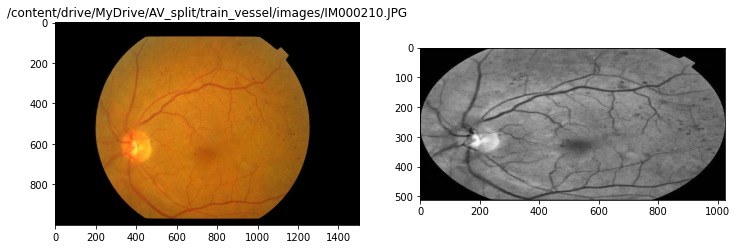

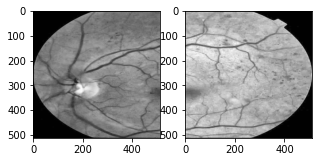

In [8]:
image_path = train_image_list[10]

original_image = cv2.imread(image_path)
patched_image_list, unpatched_image = image_to_patch(image_path, "IMAGE", preprocess_image, PATCH_SIZE)
patched_image = np.array(patched_image_list)

print(patched_image.min(), patched_image.max())
print(patched_image.shape)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title(image_path)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(unpatched_image, cmap='gray')

plt.show()

rows = 1
columns = patched_image.shape[0]

fig = plt.figure(figsize=(5, 5))
for i in range(1, (rows * columns + 1)):
    fig.add_subplot(rows, columns, i)
    img = patched_image[i-1]
    plt.imshow(img,cmap='gray')

plt.show()

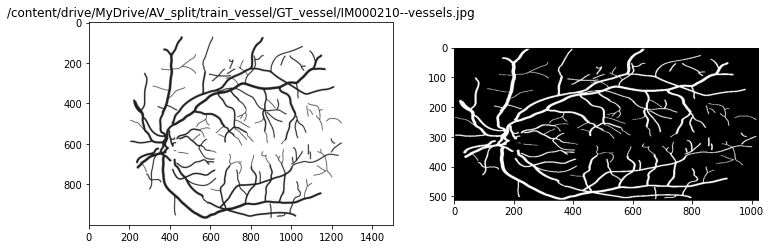

0.0 1.0
(2, 512, 512)
[0. 1.]


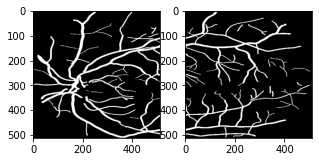

In [9]:
vessel_mask_path = train_vessel_mask_list[10]
original_vessel_mask = cv2.imread(vessel_mask_path, cv2.IMREAD_GRAYSCALE)

patched_mask_list, unpatcified_mask = image_to_patch(vessel_mask_path, "VESSEL_MASK", preprocess_vessel_mask, PATCH_SIZE)
patched_mask = np.array(patched_mask_list)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title(vessel_mask_path)
plt.imshow(cv2.cvtColor(original_vessel_mask, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(unpatcified_mask, cmap='gray')

plt.show()

print(patched_mask.min(), patched_mask.max())
print(patched_mask.shape)
print(np.unique(patched_mask))

rows = 1
columns = patched_image.shape[0]

fig = plt.figure(figsize=(5, 5))
for i in range(1, (rows * columns + 1)):
    fig.add_subplot(rows, columns, i)
    img = patched_mask[i-1]
    plt.imshow(img,cmap='gray')

plt.show()

In [10]:
train_image_dataset = []
train_vessel_mask_dataset = []

for image_path in train_image_list:
    patched_image, unpatched_image = image_to_patch(image_path, "IMAGE", preprocess_image, PATCH_SIZE)
    train_image_dataset += patched_image

for vessel_mask_path in train_vessel_mask_list:
    patched_mask, unpatched_mask = image_to_patch(vessel_mask_path, "VESSEL_MASK", preprocess_vessel_mask, PATCH_SIZE)
    train_vessel_mask_dataset += patched_mask

train_image_dataset = np.array(train_image_dataset)
train_image_dataset = np.expand_dims(train_image_dataset, axis=-1)
train_vessel_mask_dataset = np.array(train_vessel_mask_dataset)
train_vessel_mask_dataset = np.expand_dims(train_vessel_mask_dataset, axis=-1)

print(train_image_dataset.shape)
print(train_vessel_mask_dataset.shape)
print(train_image_dataset.max(), train_vessel_mask_dataset.max())
print(train_image_dataset.min(), train_vessel_mask_dataset.min())

(72, 512, 512, 1)
(72, 512, 512, 1)
1.0 1.0
0.003921569 0.0


In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_image_dataset, train_vessel_mask_dataset, test_size=0.3, random_state=0)

In [12]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50, 512, 512, 1) (50, 512, 512, 1)
(22, 512, 512, 1) (22, 512, 512, 1)


In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

def IoU_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)

In [14]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4, training=True)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5, training=True)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = IoU_loss, metrics = ['accuracy', IoU_coef])
    

    if(pretrained_weights):
    	  model=keras.models.load_model(pretrained_weights)

    return model

In [15]:
model = unet(input_size=(PATCH_SIZE, PATCH_SIZE, 1))

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
history = model.fit(x_train, y_train, 
                    verbose = 1,
                    batch_size = 3,
                    validation_data = (x_test, y_test), 
                    shuffle = False,
                    epochs = 150,
                    steps_per_epoch = 10)

Epoch 1/150
10/10 [==============================] - 49s 2s/step - loss: -0.1669 - accuracy: 0.8757 - IoU_coef: 0.1669 - val_loss: -0.0988 - val_accuracy: 0.8684 - val_IoU_coef: 0.1012
Epoch 2/150
10/10 [==============================] - 27s 3s/step - loss: -0.2407 - accuracy: 0.9053 - IoU_coef: 0.2400 - val_loss: -0.1048 - val_accuracy: 0.8948 - val_IoU_coef: 0.1074
Epoch 3/150
10/10 [==============================] - 14s 1s/step - loss: -0.2747 - accuracy: 0.9092 - IoU_coef: 0.2747 - val_loss: -0.1121 - val_accuracy: 0.9039 - val_IoU_coef: 0.1147
Epoch 4/150
10/10 [==============================] - 13s 1s/step - loss: -0.2795 - accuracy: 0.9105 - IoU_coef: 0.2787 - val_loss: -0.1031 - val_accuracy: 0.8889 - val_IoU_coef: 0.1048
Epoch 5/150
10/10 [==============================] - 14s 1s/step - loss: -0.2938 - accuracy: 0.9145 - IoU_coef: 0.2938 - val_loss: -0.0906 - val_accuracy: 0.8958 - val_IoU_coef: 0.0913
Epoch 6/150
10/10 [==============================] - 14s 1s/step - loss: -0

In [17]:
test_image_list = glob.glob(TEST_IMAGE_PATH + '/*.JPG')
test_image_list.sort()

test_vessel_mask_list = glob.glob(TEST_VESSEL_MASK_PATH + '/*.jpg')
test_vessel_mask_list.sort()

In [18]:
test_image_list = glob.glob(TEST_IMAGE_PATH + '/*.JPG')
test_image_list.sort()

test_vessel_mask_list = glob.glob(TEST_VESSEL_MASK_PATH + '/*.jpg')
test_vessel_mask_list.sort()

1/1 [==============================] - 0s 27ms/step
Execution time:  0:00:00.388970


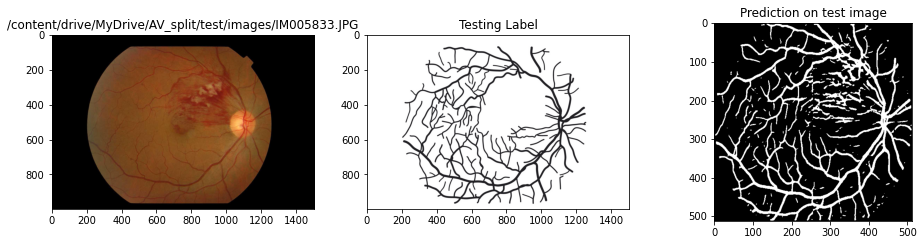

In [22]:
from datetime import datetime 

test_image_number = random.randint(0, len(test_image_list)-1)

reconstructed_image = []
test_img = cv2.imread(test_image_list[test_image_number])
gt = cv2.imread(test_vessel_mask_list[test_image_number])

predicted_patches = []
start = datetime.now()   

test = preprocess_image(test_img, PATCH_SIZE)
patches = patchify(test, (PATCH_SIZE, PATCH_SIZE), step=PATCH_SIZE) 

for i in range(patches.shape[0]):
      for j in range(patches.shape[1]):
          single_patch = patches[i,j,:,:]
          single_patch_norm = (single_patch.astype('float32')) 
          single_patch_norm = np.expand_dims(np.array(single_patch_norm), axis=-1)
          single_patch_input = np.expand_dims(single_patch_norm, 0)
          single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8)
          predicted_patches.append(single_patch_prediction)
          
predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], PATCH_SIZE, PATCH_SIZE))

reconstructed_image = unpatchify(predicted_patches_reshaped, test.shape) 
reconstructed_image = cv2.resize(reconstructed_image, (512, 512))

stop = datetime.now()
print('Execution time: ',(stop-start)) #computation time

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title(test_image_list[test_image_number])
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(gt, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(reconstructed_image, cmap='gray')
plt.show()

(512, 512)
1 0
[0 1]


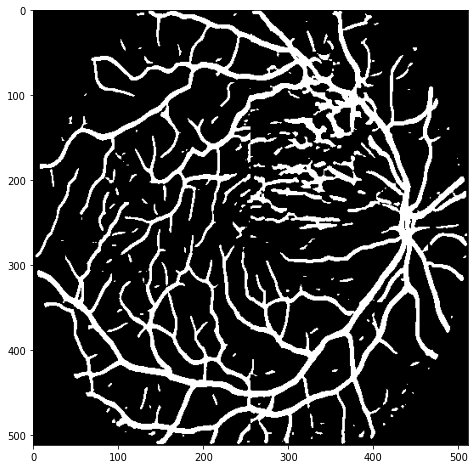

(512, 512, 1)
1 0
[0 1]


In [23]:
print(reconstructed_image.shape)
print(reconstructed_image.max(), reconstructed_image.min())
print(np.unique(reconstructed_image))

predicted_image = np.expand_dims(reconstructed_image, axis=-1)

plt.figure(figsize=(16, 8))
plt.imshow(predicted_image, cmap='gray')
plt.show()

print(predicted_image.shape)
print(predicted_image.max(), predicted_image.min())
print(np.unique(predicted_image))

**PREDICT THE NEXT 20 DATASET**

In [24]:
PATH = '/content/drive/MyDrive/AV_split/'

TRAIN_PATH = PATH+'train_av/'
TRAIN_IMAGE_PATH = TRAIN_PATH + 'images/'
TRAIN_VESSEL_MASK_PATH = TRAIN_PATH + 'GT_vessel/'
TRAIN_ARTERY_MASK_PATH = TRAIN_PATH + 'GT_artery/'
TRAIN_VEIN_MASK_PATH = TRAIN_PATH + 'GT_vein/'

TEST_PATH = PATH+'test_av/'
TEST_IMAGE_PATH = TEST_PATH + 'images/'
TEST_VESSEL_MASK_PATH = TEST_PATH + 'GT_vessel/'
TEST_ARTERY_MASK_PATH = TEST_PATH + 'GT_artery/'
TEST_VEIN_MASK_PATH = TEST_PATH + 'GT_vein/'

PATCH_SIZE = 512

VEIN_COLOR = [0, 0, 255]      
ARTERY_COLOR = [255, 0, 0]     
BLACK_BG_COLOR = [0, 0, 0]
VESSEL_COLOR = [255, 255, 255]

In [25]:
train_av_image_paths = glob.glob(TRAIN_IMAGE_PATH + "/*.JPG")
train_av_image_paths.sort()

train_av_vessel_paths = glob.glob(TRAIN_VESSEL_MASK_PATH + "/*.jpg")
train_av_vessel_paths.sort()

train_av_artery_paths = glob.glob(TRAIN_ARTERY_MASK_PATH + "/*.jpg")
train_av_artery_paths.sort()

train_av_vein_paths = glob.glob(TRAIN_VEIN_MASK_PATH + "/*.jpg")
train_av_vein_paths.sort()

predicted_vessel_dataset = []
gt_vessel_dataset = []

In [26]:
for image_path, vessel_path in zip(train_av_image_paths, train_av_vessel_paths):
      image_patch_list, _ = image_to_patch(image_path, "IMAGE", preprocess_image, PATCH_SIZE)
      gt_vessel = cv2.imread(vessel_path)
      gt_vessel = preprocess_vessel_mask(gt_vessel, PATCH_SIZE)

      predicted_patches = []

      for patch in image_patch_list:
          patch = np.array(patch)
          patch = patch.astype(np.float32)
          patch = np.expand_dims(np.array(patch), axis=-1)
          single_patch_input = np.expand_dims(patch, 0)
          single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8)
          predicted_patches.append(single_patch_prediction)

      predicted_patches = np.array(predicted_patches)
      predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], PATCH_SIZE, PATCH_SIZE))
      reconstructed_image = unpatchify(predicted_patches_reshaped, test.shape)

      predicted_vessel_dataset.append(reconstructed_image)
      gt_vessel_dataset.append(gt_vessel)
  
predicted_vessel_dataset = np.array(predicted_vessel_dataset)

1/1 [==============================] - 0s 22ms/step


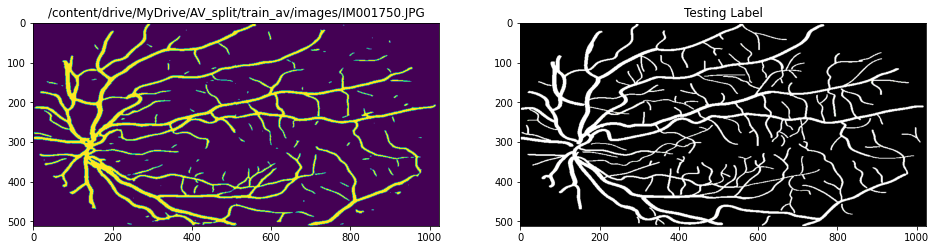

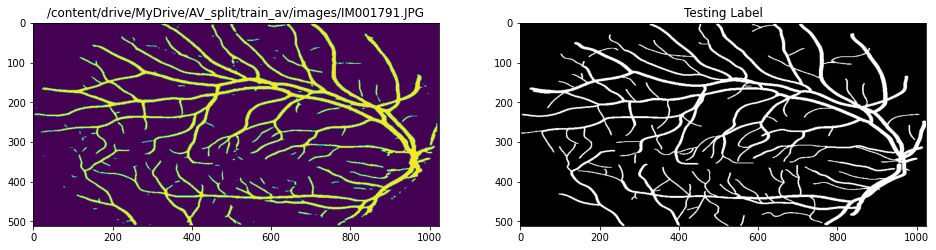

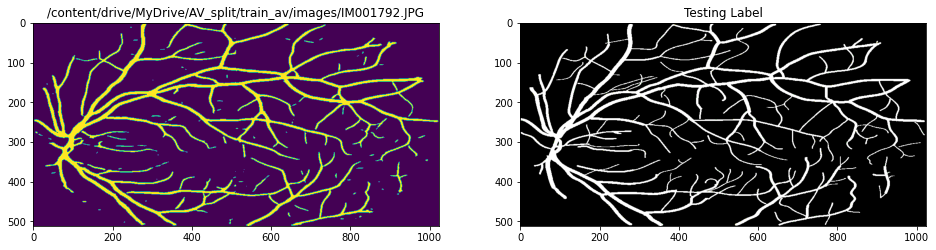

In [27]:
for i in range(1, 4):
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.title(train_av_image_paths[i])
    plt.imshow(predicted_vessel_dataset[i])
    plt.subplot(122)
    plt.title('Testing Label')
    plt.imshow(gt_vessel_dataset[i], cmap='gray')
    plt.show()

**TRAIN PREDICTED VESSEL TO ARTERY VEIN**

In [28]:
def vessel_image_to_patch(image, patch_size):
    image_dataset = unpatched_image = []

    image = (image).astype('uint8')
    rgb_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) * 255

    patches_image = patchify(rgb_image, (patch_size, patch_size, 3), step=patch_size)
    unpatched_image = unpatchify(patches_image, rgb_image.shape)
    
    for i in range(patches_image.shape[0]):
        for j in range(patches_image.shape[1]):
            single_patch = patches_image[i,j,:,:]
            single_patch = (single_patch).astype('float32')
            image_dataset.append(single_patch[0])

    return image_dataset, unpatched_image

In [29]:
def preprocess_vessel_mask(mask, patch_size):
    thresh = 128
    mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]

    mask = mask[70:970, 200:1255]
    
    SIZE_X = (mask.shape[1]//patch_size)*patch_size 
    SIZE_Y = (mask.shape[0]//patch_size)*patch_size     

    mask = cv2.resize(mask, (SIZE_X, SIZE_Y))
  
    mask = 255 - mask
    mask = mask / 255

    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return mask

def preprocess_vein_mask(image, patch_size):
    mask = preprocess_vessel_mask(image, patch_size)

    mask = (mask).astype('uint8')
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * 255

    mask[np.all(mask == VESSEL_COLOR, axis=-1)] = VEIN_COLOR

    return (mask).astype('float32')

def preprocess_artery_mask(image, patch_size):
    mask = preprocess_vessel_mask(image, patch_size)

    mask = (mask).astype('uint8')
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * 255

    mask[np.all(mask == VESSEL_COLOR, axis=-1)] = ARTERY_COLOR

    return (mask).astype('float32')

def merge_and_mask_labeling(vein_mask, artery_mask):
    result = cv2.add(vein_mask, artery_mask)

    mask_label = np.zeros(result.shape, dtype=np.uint8)
    mask_label[np.all(result == ARTERY_COLOR, axis=-1)] = 1
    mask_label[np.all(result == VEIN_COLOR, axis=-1)] = 2                                   

    return result, mask_label[:,:,0]                                            

def mask_to_patch(vein_path, artery_path, patch_size, visualize = False):
    mask_dataset = []

    vein_image = cv2.imread(vein_path, cv2.IMREAD_GRAYSCALE)
    vein_mask = preprocess_vein_mask(vein_image, patch_size)

    artery_image = cv2.imread(artery_path, cv2.IMREAD_GRAYSCALE)
    artery_mask = preprocess_artery_mask(artery_image, patch_size)

    if visualize:
        merged_mask, _ = merge_and_mask_labeling(vein_mask, artery_mask)
    else:
        _, merged_mask = merge_and_mask_labeling(vein_mask, artery_mask)

    patches_mask = patchify(merged_mask, (patch_size, patch_size), step=patch_size)
    unpatched_mask = unpatchify(patches_mask, merged_mask.shape)
    
    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch = patches_mask[i,j,:,:]
            single_patch = (single_patch).astype('float32')
            mask_dataset.append(single_patch)

    return mask_dataset, unpatched_mask

In [30]:
train_image_dataset = []
train_mask_dataset = []

for image_path in predicted_vessel_dataset:
    patched_image, predicted_vessel_dataset = vessel_image_to_patch(image_path, PATCH_SIZE)
    train_image_dataset += patched_image

for (vein_mask_path, artery_mask_path) in zip(train_av_vein_paths, train_av_artery_paths):
    patched_mask, unpatched_mask = mask_to_patch(vein_mask_path, artery_mask_path, PATCH_SIZE, visualize = False)
    train_mask_dataset += patched_mask

train_image_dataset = np.array(train_image_dataset)
train_mask_dataset = np.array(train_mask_dataset)

print(train_image_dataset.shape)
print(train_mask_dataset.shape)
print(train_image_dataset.max(), train_mask_dataset.max())
print(train_image_dataset.min(), train_mask_dataset.min())

(40, 512, 512, 3)
(40, 512, 512)
255.0 2.0
0.0 0.0


In [31]:
from tensorflow.keras.utils import to_categorical

n_classes = len(np.unique(train_mask_dataset))
mask_categories = to_categorical(train_mask_dataset, num_classes=n_classes)

print(np.unique(mask_categories))
print(mask_categories.shape)

[0. 1.]
(40, 512, 512, 3)


<Figure size 360x360 with 0 Axes>

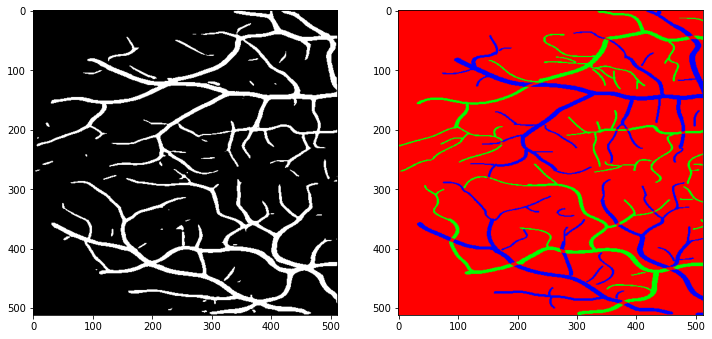

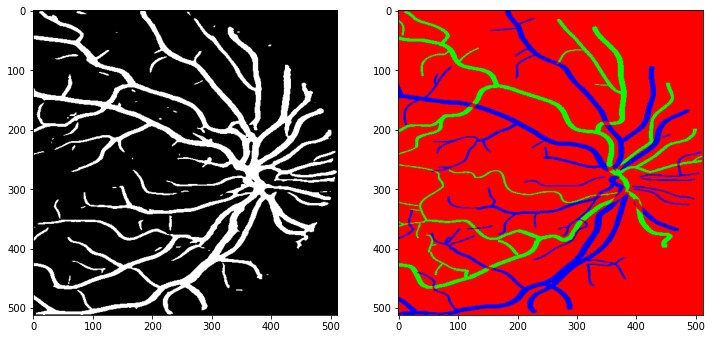

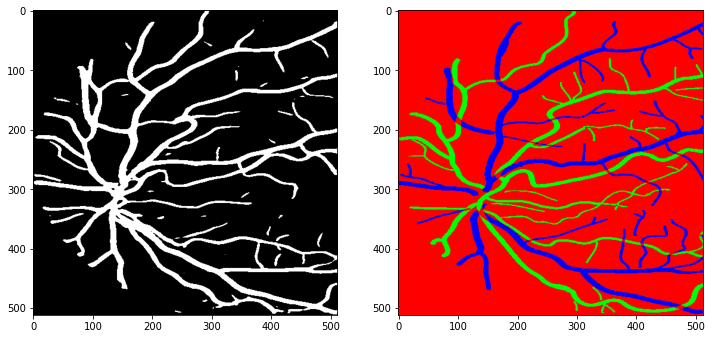

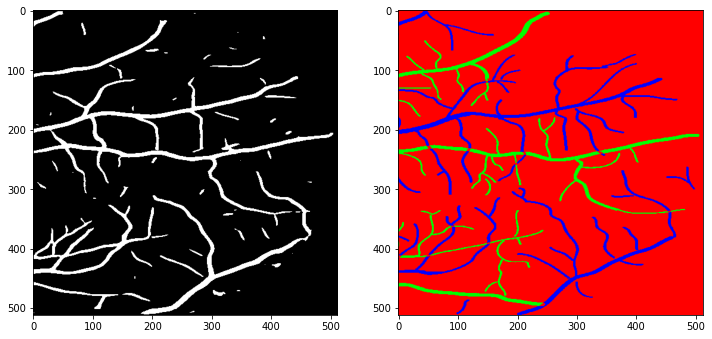

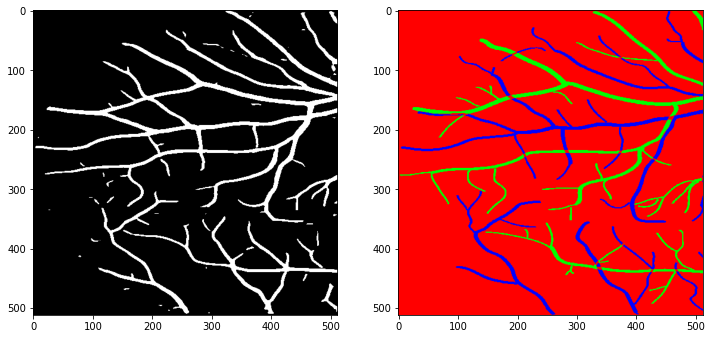

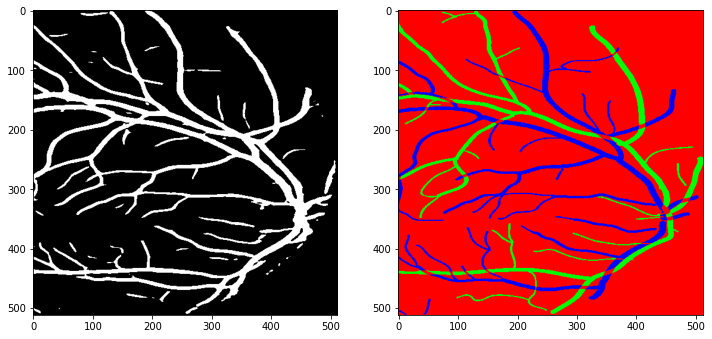

In [32]:
rows = 3
columns = 2

fig = plt.figure(figsize=(5, 5))
for i in range(1, (rows * columns + 1)):
    plt.figure(figsize=(12, 6))

    plt.subplot(121)
    plt.imshow(train_image_dataset[i-1])

    plt.subplot(122)
    plt.imshow(mask_categories[i-1])
    
    plt.show()
plt.show()

In [33]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_image_dataset, mask_categories, test_size=0.2, random_state=0)

In [34]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(32, 512, 512, 3) (32, 512, 512, 3)
(8, 512, 512, 3) (8, 512, 512, 3)


In [35]:
IMG_HEIGHT = x_train.shape[1]
IMG_WIDTH  = x_train.shape[2]
IMG_CHANNELS = x_train.shape[3]

print(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

512 512 3


In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [37]:
from keras.optimizers import Adam

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = metrics)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 512, 512, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_2 (Dropout)            (None, 512, 512, 16  0           ['conv2d_24[0][0]']              
                                )                                                           

In [38]:
batch_size = 3
epoch = 150
train_steps = len(x_train)//batch_size
valid_steps = len(x_test)//batch_size

print(train_steps, valid_steps)

10 2


In [39]:
history = model.fit(x_train, y_train, 
                    batch_size = 3, 
                    verbose = 1, 
                    epochs = epoch, 
                    validation_data = (x_test, y_test), 
                    steps_per_epoch = 10,
                    shuffle = False)

Epoch 1/150
10/10 [==============================] - 9s 332ms/step - loss: 63.6769 - accuracy: 0.6257 - jacard_coef: 0.4315 - val_loss: 30.5295 - val_accuracy: 0.6968 - val_jacard_coef: 0.4334
Epoch 2/150
10/10 [==============================] - 4s 167ms/step - loss: 39.8210 - accuracy: 0.6819 - jacard_coef: 0.4665 - val_loss: 19.1434 - val_accuracy: 0.7729 - val_jacard_coef: 0.4758
Epoch 3/150
10/10 [==============================] - 2s 161ms/step - loss: 31.0710 - accuracy: 0.7385 - jacard_coef: 0.5153 - val_loss: 16.4239 - val_accuracy: 0.8337 - val_jacard_coef: 0.5395
Epoch 4/150
10/10 [==============================] - 2s 162ms/step - loss: 26.1227 - accuracy: 0.7838 - jacard_coef: 0.5644 - val_loss: 14.0724 - val_accuracy: 0.8594 - val_jacard_coef: 0.5731
Epoch 5/150
10/10 [==============================] - 2s 167ms/step - loss: 22.0025 - accuracy: 0.8107 - jacard_coef: 0.5935 - val_loss: 12.3264 - val_accuracy: 0.8690 - val_jacard_coef: 0.5917
Epoch 6/150
10/10 [================

In [40]:
# IOU
y_pred=model.predict(x_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

# Using built in keras function for IoU
from tensorflow.keras.metrics import MeanIoU

n_classes = len(np.unique(train_mask_dataset))
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 2s 2s/step
Mean IoU = 0.29528832


In [44]:
test_image_list = glob.glob(TEST_IMAGE_PATH + '/*.JPG')
test_image_list.sort()

test_vein_mask_list = glob.glob(TEST_VEIN_MASK_PATH + '/*.jpg')
test_vein_mask_list.sort()

test_artery_mask_list = glob.glob(TEST_ARTERY_MASK_PATH + '/*.jpg')
test_artery_mask_list.sort()

1/1 [==============================] - 0s 30ms/step


(512, 512)
[0 1 2]


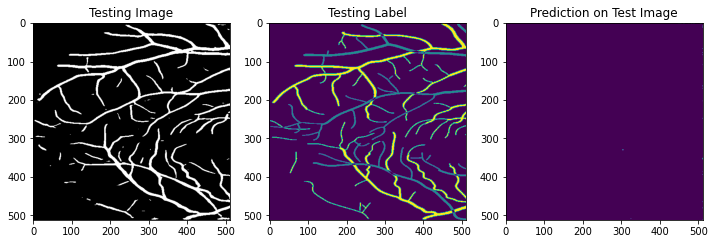

In [45]:
import random

test_img_number = random.randint(0, len(x_test))
test_img = x_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]

test_img_input = np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]

print(predicted_img.shape)
print(np.unique(predicted_img))

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(predicted_img)
plt.show()